sdi2100081 - Lazanaki Artemis

In [ ]:
import numpy as np
import pennylane as qml
import pennylane.numpy as pnp
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd

def load_data():
    c1_train = np.loadtxt("class1_data_train.dat")
    c2_train = np.loadtxt("class2_data_train.dat")
    c1_test = np.loadtxt("class1_data_test.dat")
    c2_test = np.loadtxt("class2_data_test.dat")
    
    def preprocess(c1, c2):
        X = np.vstack((c1, c2))
        y = np.hstack((np.ones(len(c1)), -1*np.ones(len(c2))))
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        return X, y
    
    return preprocess(c1_train, c2_train), preprocess(c1_test, c2_test)

def create_vqc(n_qubits, n_layers):
    dev = qml.device("default.qubit", wires=n_qubits)
    
    def layer(params):
        for i in range(n_qubits):
            qml.RX(params[i, 0], wires=i)
            qml.RY(params[i, 1], wires=i)
            qml.RZ(params[i, 2], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    
    @qml.qnode(dev, interface="autograd")
    def circuit(params, x):
        qml.AngleEmbedding(x, wires=range(n_qubits), rotation='Y')
        for layer_params in params:
            layer(layer_params)
        return qml.expval(qml.PauliZ(0))
    
    return circuit

def run_vqc(n_layers, opt_name):
    np.random.seed(42)
    pnp.random.seed(42)
    n_qubits = 2
    stepsize = 0.1
    epochs = 50
    (X_train, y_train), (X_test, y_test) = load_data()
    circuit = create_vqc(n_qubits, n_layers)
    
    params = pnp.array(0.3 * np.random.randn(n_layers, n_qubits, 3), requires_grad=True)
    bias = pnp.array(0.0, requires_grad=True)
    
    opt_dict = {
        "Adam": qml.AdamOptimizer(stepsize=stepsize),
        "Nesterov": qml.NesterovMomentumOptimizer(stepsize=stepsize),
        "Adagrad": qml.AdagradOptimizer(stepsize=stepsize)
    }
    opt = opt_dict[opt_name]
    
    def loss_fn(w, b):
        preds = [circuit(w, x) + b for x in X_train]
        return pnp.mean((pnp.stack(preds) - y_train)**2)
    
    best_test_acc = 0
    best_epoch = 0
    
    for epoch in range(1, epochs + 1):
        params, bias = opt.step(loss_fn, params, bias)
        
        preds_test = [int(pnp.sign(circuit(params, x) + bias)) for x in X_test]
        acc_test = np.mean(np.array(preds_test) == y_test)
        
        if acc_test > best_test_acc:
            best_test_acc = acc_test
            best_epoch = epoch
            best_preds = preds_test.copy()
    
    report = classification_report(y_test, best_preds, output_dict=True)
    return {
        "layers": n_layers,
        "optimizer": opt_name,
        "best_test_acc": best_test_acc,
        "epoch": best_epoch,
        "precision": report["1.0"]["precision"] if "1.0" in report else report["1"]["precision"] if 1 in report else None,
        "recall": report["1.0"]["recall"] if "1.0" in report else report["1"]["recall"] if 1 in report else None,
        "f1": report["1.0"]["f1-score"] if "1.0" in report else report["1"]["f1-score"] if 1 in report else None
    }

# Run full grid of experiments
results = []
for layers in [1, 2, 3]:
    for opt in ["Adam", "Nesterov", "Adagrad"]:
        result = run_vqc(layers, opt)
        results.append(result)

df = pd.DataFrame(results)
print(df)

   layers optimizer  best_test_acc  epoch  precision  recall        f1
0       1      Adam          0.725     12   0.800000    0.60  0.685714
1       1  Nesterov          0.725     11   0.695652    0.80  0.744186
2       1   Adagrad          0.750     21   0.692308    0.90  0.782609
3       2      Adam          0.950     11   1.000000    0.90  0.947368
4       2  Nesterov          0.950     14   1.000000    0.90  0.947368
5       2   Adagrad          0.950     23   0.950000    0.95  0.950000
6       3      Adam          0.950      5   1.000000    0.90  0.947368
7       3  Nesterov          0.950      9   0.950000    0.95  0.950000
8       3   Adagrad          0.925     12   0.947368    0.90  0.923077


Best Test Accuracy: 0.9500 at Epoch 9


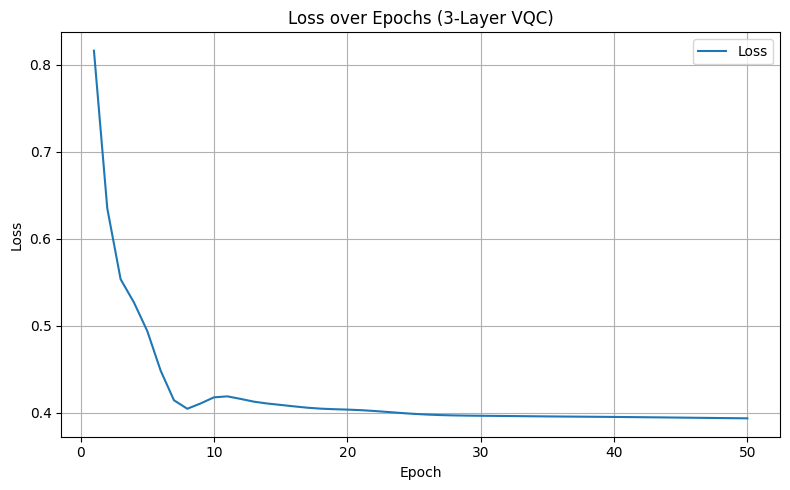

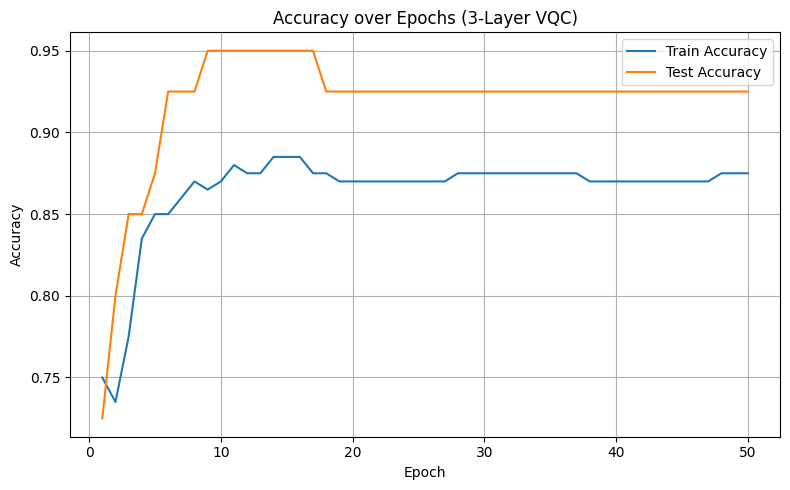

C:\Users\Artemis\AppData\Local\Temp\ipykernel_20268\2830398536.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


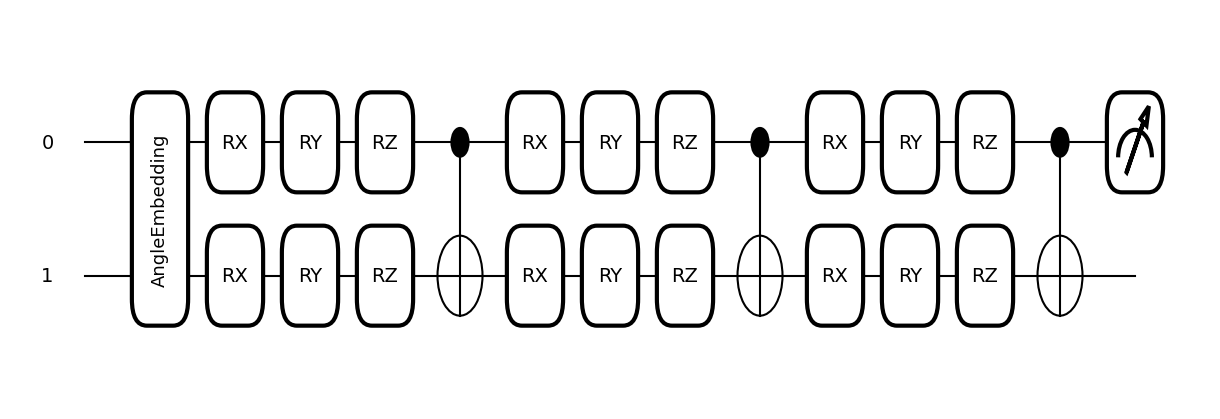

In [ ]:
import matplotlib.pyplot as plt

def train_plot_best_vqc():
    np.random.seed(42)
    pnp.random.seed(42)

    (X_train, y_train), (X_test, y_test) = load_data()
    n_qubits, n_layers, epochs = 2, 3, 50
    stepsize = 0.1

    circuit = create_vqc(n_qubits, n_layers)
    params = pnp.array(0.3 * np.random.randn(n_layers, n_qubits, 3), requires_grad=True)
    bias = pnp.array(0.0, requires_grad=True)
    opt = qml.NesterovMomentumOptimizer(stepsize=stepsize)

    def loss_fn(w, b):
        preds = [circuit(w, x) + b for x in X_train]
        return pnp.mean((pnp.stack(preds) - y_train) ** 2)

    losses, train_accs, test_accs = [], [], []
    best_test_acc, best_epoch = 0, 0

    for epoch in range(1, epochs + 1):
        params, bias = opt.step(loss_fn, params, bias)

        pred_train = [int(pnp.sign(circuit(params, x) + bias)) for x in X_train]
        pred_test = [int(pnp.sign(circuit(params, x) + bias)) for x in X_test]
        acc_train = np.mean(np.array(pred_train) == y_train)
        acc_test = np.mean(np.array(pred_test) == y_test)
        l = loss_fn(params, bias)

        train_accs.append(acc_train)
        test_accs.append(acc_test)
        losses.append(l)

        if acc_test > best_test_acc:
            best_test_acc = acc_test
            best_epoch = epoch

    print(f"Best Test Accuracy: {best_test_acc:.4f} at Epoch {best_epoch}")
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(losses)+1), losses, label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs (3-Layer VQC)")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig("vqc_loss_plot.png")
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_accs)+1), train_accs, label="Train Accuracy")
    plt.plot(range(1, len(test_accs)+1), test_accs, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs (3-Layer VQC)")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig("vqc_accuracy_plot.png")
    plt.show()

    dummy_params = np.zeros((n_layers, n_qubits, 3))
    x_dummy = np.zeros(n_qubits)

    fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(dummy_params, x_dummy)
    fig.set_size_inches(12, 4)
    fig.tight_layout()
    plt.savefig("vqc_circuit_diagram.png")
    plt.show()
    return losses, train_accs, test_accs


train_plot_best_vqc()

In [103]:
from sklearn.svm import SVC

(X_train, y_train), (X_test, y_test) = load_data()
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
report = classification_report(y_test, y_pred)
print("SVM Classification Report:")
print(report)

SVM Classification Report:
              precision    recall  f1-score   support

        -1.0       0.95      1.00      0.98        20
         1.0       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



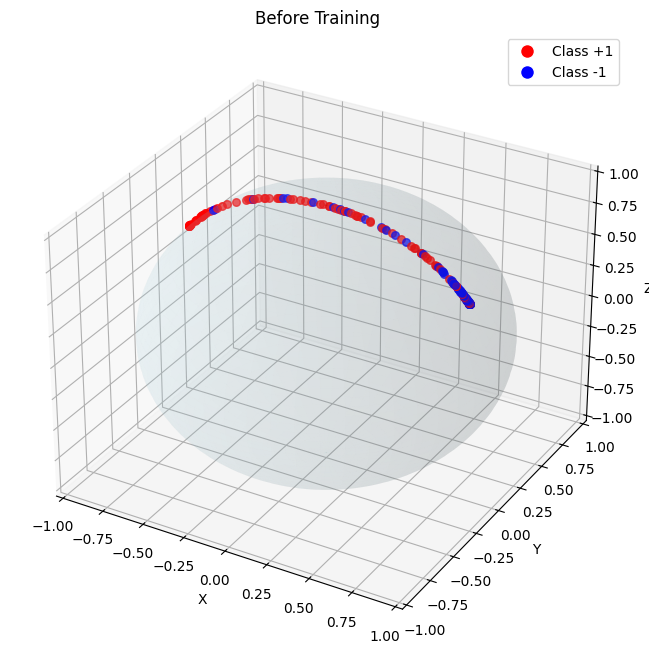

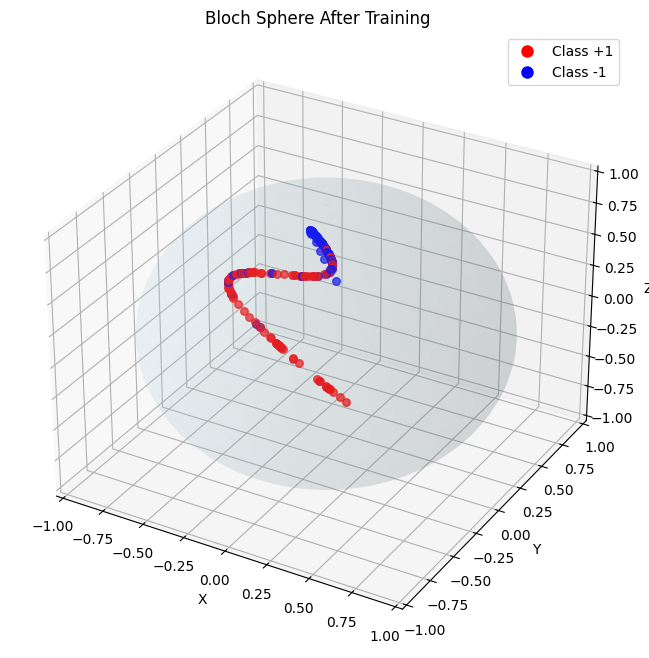

In [ ]:
pauli_matrices = {
    "X": np.array([[0, 1], [1, 0]]),
    "Y": np.array([[0, -1j], [1j, 0]]),
    "Z": np.array([[1, 0], [0, -1]])
}

n_qubits = 2
n_layers = 3
np.random.seed(42)
pnp.random.seed(42)
params = pnp.array(0.3 * np.random.randn(n_layers, n_qubits, 3), requires_grad=True)

dev = qml.device("default.qubit", wires=n_qubits)
def layer(params):
        for i in range(n_qubits):
            qml.RX(params[i, 0], wires=i)
            qml.RY(params[i, 1], wires=i)
            qml.RZ(params[i, 2], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev, interface="autograd")
def state_circuit(params, x):
    qml.AngleEmbedding(x, wires=range(n_qubits), rotation='Y')
    for layer_params in params:
        layer(layer_params)
    return qml.state()

def get_bloch_coordinates(state):
    rho = np.outer(state, state.conj()) 
    rho0 = np.zeros((2, 2), dtype=complex)
    rho0[0, 0] = rho[0, 0] + rho[1, 1]
    rho0[0, 1] = rho[0, 2] + rho[1, 3]
    rho0[1, 0] = rho[2, 0] + rho[3, 1]
    rho0[1, 1] = rho[2, 2] + rho[3, 3]

    x = np.real(np.trace(rho0 @ pauli_matrices["X"]))
    y = np.real(np.trace(rho0 @ pauli_matrices["Y"]))
    z = np.real(np.trace(rho0 @ pauli_matrices["Z"]))
    return np.array([x, y, z])


def plot_bloch_sphere(X, y, params, state_circuit, title, num_points=20):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(xs, ys, zs, color='lightblue', alpha=0.1)

    for i in range(min(num_points, len(X))):
        if params is not None:
            state = state_circuit(params, X[i])
        else:
            state = state_circuit(X[i])
        coords = get_bloch_coordinates(state)
        color = 'red' if y[i] == 1 else 'blue'
        ax.scatter(coords[0], coords[1], coords[2], color=color, s=30, alpha=0.7)
    
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)

    red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Class +1')
    blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Class -1')
    ax.legend(handles=[red_patch, blue_patch])

    return fig

@qml.qnode(dev, interface="autograd")
def state_circuit_before_training(x):
    qml.AngleEmbedding(x, wires=range(n_qubits), rotation='Y')
    return qml.state()

c1_train = np.loadtxt("class1_data_train.dat")
c2_train = np.loadtxt("class2_data_train.dat")

X_train = np.vstack((c1_train, c2_train))
y_train = np.array([1] * len(c1_train) + [-1] * len(c2_train))
y_train = y_train.astype(int)

X_train = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)

fig = plot_bloch_sphere(X_train, y_train, None, state_circuit_before_training, "Before Training", num_points=200)
plt.savefig("bloch_before_training.png")
plt.show()

c1_train = np.loadtxt("class1_data_train.dat")
c2_train = np.loadtxt("class2_data_train.dat")

X_train = np.vstack((c1_train, c2_train))
y_train = np.array([1] * len(c1_train) + [-1] * len(c2_train))
y_train = y_train.astype(int)

X_train = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)

fig = plot_bloch_sphere(X_train, y_train, params, state_circuit, "Bloch Sphere After Training", num_points=200)
plt.savefig("bloch_after_training.png")
plt.show()

